In [174]:
#import libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

from imblearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from causallift import CausalLift
import xgboost
import lightgbm as lgb
from lightgbm import LGBMClassifier


from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklift.models import TwoModels
from sklift.models import SoloModel
from sklift.models import ClassTransformation
from sklift.metrics import qini_auc_score
from sklift.viz import plot_qini_curve
from sklift.viz import plot_uplift_curve
from sklift.viz import plot_uplift_by_percentile

%matplotlib inline

In [2]:
#Read the dataset
df = pd.read_csv("criteo-uplift-data.csv")

In [3]:
#Given the treatment, exposure and visits, how is the conversion?
df.groupby(['treatment','exposure','visit']).agg({'conversion':['mean','sum','count']})

conversion                 
                               mean    sum     count
treatment exposure visit                            
0         0        0       0.000000      0   2016832
                   1       0.050721   4063     80105
1         0        0       0.000000      0  11055129
                   1       0.034259  13680    399314
          1        0       0.000000      0    250702
                   1       0.129745  23031    177510

In [42]:
users_to_remove = df[(df['treatment'] == 1 ) & (df['exposure']==0)]

#New df where treatment column is dropped
df_ml = df.drop(users_to_remove.index).reset_index().drop(['index','treatment', 'visit'], axis = 1)

In [40]:
'''scaled = preprocessing.scale(df_ml.drop(['conversion','exposure'], axis = 1).values)
df_sca = pd.DataFrame(data=scaled, columns = df_ml.drop(['conversion','exposure'], axis = 1).columns)
df_exposure = df_ml['exposure']
df_conversion = df_ml['conversion']
'''

In [144]:
#scaled = preprocessing.MinMaxScaler()
scaled = preprocessing.StandardScaler()
df_sca = scaled.fit_transform(df_ml.drop(['conversion','exposure'], axis=1))

#df_sca = pd.DataFrame(data=scaled, columns = df_ml.drop(['conversion','exposure'], axis = 1).columns)
df_exposure = df_ml['exposure']
df_conversion = df_ml['conversion']

In [145]:
X=pd.DataFrame(df_sca.tolist())
treatment = df_ml['exposure']
y = df_ml['conversion']

<AxesSubplot:>

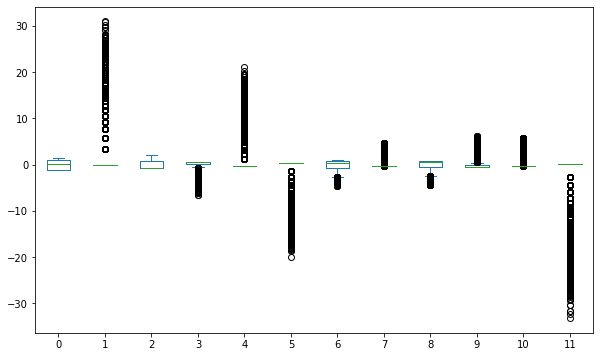

In [146]:
X.plot.box(figsize=(10,6))

In [147]:
X_train, X_test, treatment_train, treatment_test, y_train, y_test = train_test_split(X,treatment,y, random_state=23, stratify=treatment, test_size=0.33)

## Testing Solo Model

In [160]:
sm = SoloModel(LogisticRegression(C= 0.01, penalty= 'elasticnet', solver= 'saga', l1_ratio=0.1, random_state=23))  # define approach
#sm = SoloModel(LGBMClassifier(boosting_type='dart', reg_alpha=0.2, reg_lambda=0.8, random_state=23))  # define approach

sm = sm.fit(X_train, y_train, treatment_train)  # fit the model
#uplift_sm = sm.predict(X_test)  # predict uplift

C:\Program Files\Python310\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [161]:
uplift_sm = sm.predict(X_test)
# AUQC = area under Qini curve = Qini coefficient
auqc = qini_auc_score(y_test, uplift_sm, treatment_test) 
print(f"Qini coefficient on full data: {auqc:.4f}")

C:\Program Files\Python310\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Program Files\Python310\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Qini coefficient on full data: 0.6973


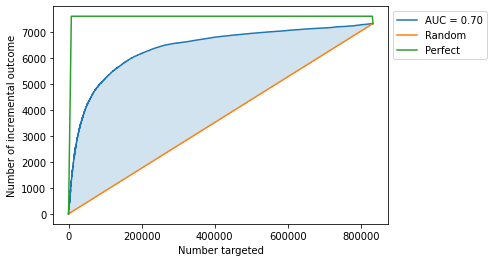

In [162]:
# with ideal Qini curve (red line)
# perfect=True

plot_qini_curve(y_test, uplift_sm, treatment_test, perfect=True);

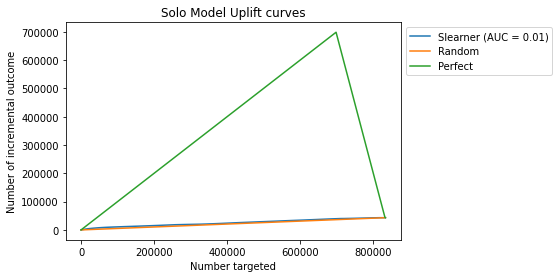

In [167]:
fig, ax = plt.subplots(1, 1)
ax.set_title('Solo Model Uplift curves')
plot_uplift_curve(y_test, uplift_sm, treatment_test,perfect=True, name='Slearner', ax=ax);

C:\Program Files\Python310\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


array([<AxesSubplot:title={'center':'Uplift by percentile\nweighted average uplift = 0.0519'}>,
       <AxesSubplot:title={'center':'Response rate by percentile'}, xlabel='Percentile'>],
      dtype=object)

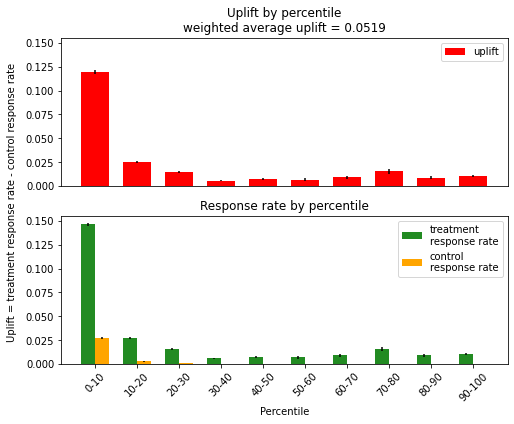

In [177]:
plot_uplift_by_percentile(y_true=y_test, uplift=uplift_sm, treatment=treatment_test, kind='bar')

### Testing Class Transformation

In [164]:
ct = ClassTransformation(LogisticRegression(C= 0.01, penalty= 'elasticnet', solver= 'saga', l1_ratio=0.1, random_state=23))  # define approach
#sm = SoloModel(LGBMClassifier(boosting_type='dart', reg_alpha=0.2, reg_lambda=0.8, random_state=23))  # define approach

ct = ct.fit(X_train, y_train, treatment_train)  # fit the model
#uplift_sm = sm.predict(X_test)  # predict uplift

In [165]:
uplift_ct = ct.predict(X_test)
# AUQC = area under Qini curve = Qini coefficient
auqc = qini_auc_score(y_test, uplift_ct, treatment_test) 
print(f"Qini coefficient on full data: {auqc:.4f}")

Qini coefficient on full data: -0.6495


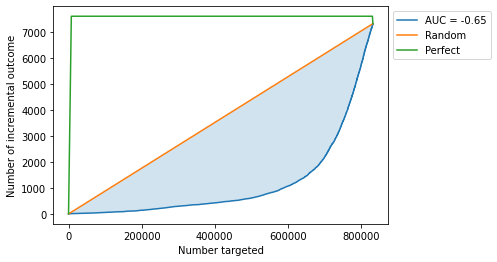

In [168]:
# with ideal Qini curve (red line)
# perfect=True

plot_qini_curve(y_test, uplift_ct, treatment_test, perfect=True);

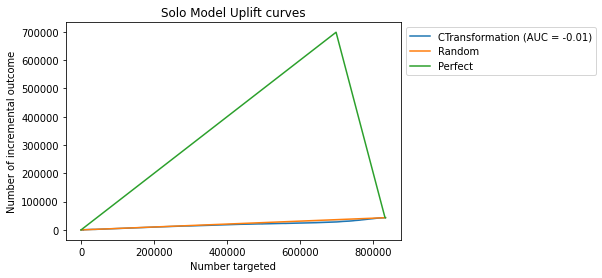

In [173]:
fig, ax = plt.subplots(1, 1)
ax.set_title('Solo Model Uplift curves')
plot_uplift_curve(y_test, uplift_ct, treatment_test,perfect=True, name='CTransformation', ax=ax);

C:\Program Files\Python310\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


array([<AxesSubplot:title={'center':'Uplift by percentile\nweighted average uplift = 0.0519'}>,
       <AxesSubplot:title={'center':'Response rate by percentile'}, xlabel='Percentile'>],
      dtype=object)

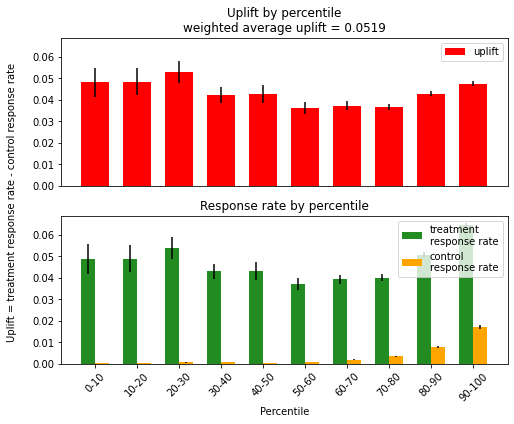

In [176]:
plot_uplift_by_percentile(y_true=y_test, uplift=uplift_ct, treatment=treatment_test, kind='bar')

## Implementing TwoModel

In [128]:
'''
treatment_model = LGBMClassifier(boosting_type='dart', reg_alpha=0.2, reg_lambda=0.8, random_state=23)
control_model = LGBMClassifier(boosting_type='dart', reg_alpha=0.2, reg_lambda=0.8, random_state=23)
LogReg = TwoModels(estimator_trmnt = treatment_model, estimator_ctrl = control_model, method='vanilla')
'''

In [148]:
treatment_model = LogisticRegression(C= 0.00001, penalty= 'elasticnet', solver= 'saga', l1_ratio=0.1, random_state=23)
control_model = LogisticRegression(C= 0.00001, penalty= 'elasticnet', solver= 'saga', l1_ratio=0.1, random_state=23)
LogReg = TwoModels(estimator_trmnt = treatment_model, estimator_ctrl = control_model, method='vanilla')

In [149]:
logreg_tm = LogReg.fit(X_train, y_train, treatment_train)
uplift_logreg = logreg_tm.predict(X_test)
# AUQC = area under Qini curve = Qini coefficient
auqc = qini_auc_score(y_test, uplift_logreg, treatment_test) 
print(f"Qini coefficient on full data: {auqc:.4f}")

Qini coefficient on full data: 0.7089


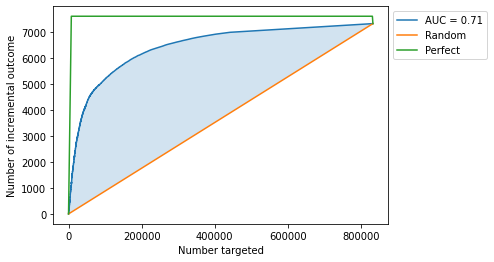

In [159]:
# with ideal Qini curve (red line)
# perfect=True

plot_qini_curve(y_test, uplift_logreg, treatment_test, perfect=True);

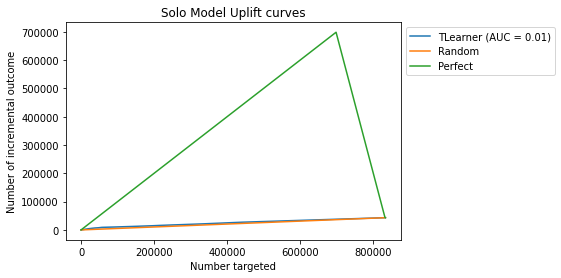

In [172]:
fig, ax = plt.subplots(1, 1)
ax.set_title('Solo Model Uplift curves')
plot_uplift_curve(y_test, uplift_logreg, treatment_test,perfect=True, name='TLearner', ax=ax);

C:\Program Files\Python310\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


array([<AxesSubplot:title={'center':'Uplift by percentile\nweighted average uplift = 0.0519'}>,
       <AxesSubplot:title={'center':'Response rate by percentile'}, xlabel='Percentile'>],
      dtype=object)

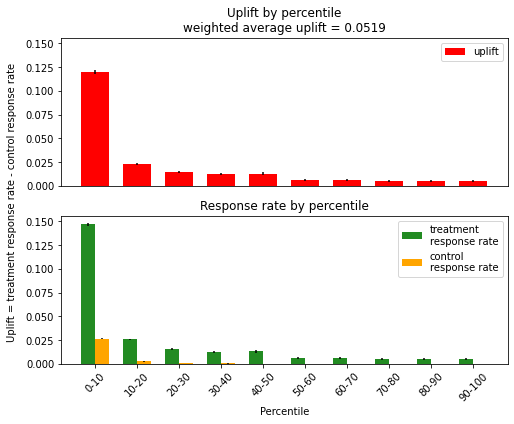

In [175]:
plot_uplift_by_percentile(y_true=y_test, uplift=uplift_logreg, treatment=treatment_test, kind='bar')

### Check Uplift on Test set

In [28]:
X_test['uplift'] = uplift_logreg.tolist()

In [30]:
# sort our test data
X_test.sort_values('uplift', ascending=False, inplace=True)
X_test.reset_index(drop=True, inplace=True)

In [152]:
X_test.tail()

,0,1,2,3,4,5,6,7,8,9,10,11
58085,-1.145323,5.796448,-0.547601,-3.494190,7.378980,-3.566604,-3.155522,1.561380,-2.802225,3.079612,1.570108,-5.967139
618686,1.087206,-0.154119,-0.804786,0.496826,-0.213038,0.264136,-0.214801,-0.290197,0.752865,-0.484372,-0.243674,0.138856
2274299,0.194477,-0.154119,-0.804786,0.084223,-0.213038,0.264136,0.723666,-0.290197,0.752865,-0.484372,-0.243674,0.138856
532442,0.717542,-0.154119,-0.804786,0.496826,-0.213038,0.264136,0.515874,-0.290197,0.752865,-0.484372,-0.243674,0.138856
172237,0.672371,-0.154119,-0.804786,0.496826,-0.213038,0.264136,0.723666,-0.290197,0.752865,-0.484372,-0.243674,0.138856


### Predict Uplift on Train Set

In [33]:
# Predict Uplift of Training Set
uplift_Xtrain = logreg_tm.predict(X_train)

In [34]:
X_train['uplift'] = uplift_Xtrain.tolist()

In [35]:
# sort our train data
X_train.sort_values('uplift', ascending=False, inplace=True)
X_train.reset_index(drop=True, inplace=True)

In [38]:
X_train.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,uplift
0,-1.205656,-0.154119,-0.154996,0.496826,20.333346,0.264136,1.016531,-0.290197,-4.038440,5.143014,1.144352,-30.414533,0.966167
1,-0.846677,-0.154119,0.142482,-2.838010,18.019374,0.264136,-1.350536,-0.290197,-3.681941,5.717501,1.720078,-33.139106,0.965686
2,-1.013998,3.326740,-0.593703,-2.386263,17.614019,-3.566604,-1.857975,1.824583,-3.723452,5.641278,1.552527,-31.652118,0.958175
3,-0.819465,3.326740,-0.643830,-3.029921,19.503846,-1.430994,-2.515746,1.814518,-3.992328,5.308735,0.109573,-28.978349,0.956747
4,-0.578404,-0.154119,-0.630838,-1.680914,19.470730,-3.566604,-1.794513,2.557228,-3.855794,5.015487,0.116932,-28.978349,0.956132


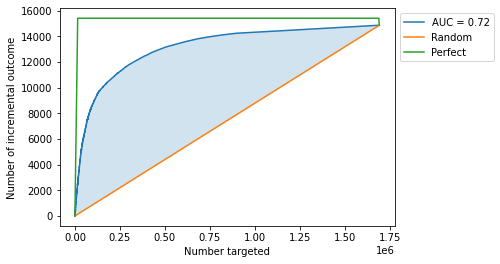

In [39]:
plot_qini_curve(y_train, uplift_Xtrain, treatment_train, perfect=True);